In [49]:
 #Import All Libraries Here
import pandas as pd
from sklearn.metrics import accuracy_score ,  roc_curve, auc , classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np

import gensim

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split

import xgboost as xgb 
import statistics
from scipy.fftpack import fft, ifft


from imblearn.over_sampling import SMOTE 
from imblearn.over_sampling import RandomOverSampler

from igraph import *


In [50]:
# Record Constants
INPUT_TRAIN_IN = "../../data/train_in.csv"
INPUT_TRAIN_OUT = "../../data/train_out.csv"  
INPUT_TEST_IN = "../../data/test_in.csv"
INPUT_TEST_OUT = "../../data/test_out.csv"

INPUT_VALIDATION_IN = "../../data/valid_in_nucleo.csv"
INPUT_VALIDATION_OUT  = "../../data/valid_out.csv"

TARGET_MODEL_PATH = '../../webapp/model_files'

WINDOW_SIZE =  50 # Final RNA Sequence will be 101 Length 
MAX_LENGTH = (WINDOW_SIZE*2) +1
ENCODING_METHOD = 4 # 1 - ANF Encoding , 2 - One Hot Encoding  , 3 - Complex Network  , 4 - Word2Vec Model
PERFORM_DATA_BALANCING = True
K_MERS_SIZE = 3

In [51]:
#Read X Varaibles and Y Varaibles

x_train_raw =  pd.read_csv(INPUT_TRAIN_IN, header=None , skiprows=1)
y_train_raw =  pd.read_csv(INPUT_TRAIN_OUT, header=None , skiprows=1)

x_test_raw =  pd.read_csv(INPUT_TEST_IN, header=None , skiprows=1)
y_test_raw =  pd.read_csv(INPUT_TEST_OUT, header=None , skiprows=1)

x_valid_raw =  pd.read_csv(INPUT_VALIDATION_IN, header=None , skiprows=1)
y_valid_raw =  pd.read_csv(INPUT_VALIDATION_OUT, header=None , skiprows=1)

print("Shape of Input Feature - " , x_train_raw.shape)

Shape of Input Feature -  (304661, 1001)


### Calculate Sequence Positions to extracted from Original Sequence 

In [52]:
middle_index = (x_train_raw.shape[1] // 2) + 1
STRAT_INEDX =middle_index - WINDOW_SIZE -1 
END_INDEX =middle_index + WINDOW_SIZE 

### Apply Graph - Complex Network

In [53]:
def feature_extraction_graph(thresholdCN):
    metrics = []
    metrics.append(mean(thresholdCN.betweenness(directed=False, weights=None)))
    metrics.append(mean(thresholdCN.degree()))
    metrics.append(thresholdCN.assortativity_degree(directed=False))  # Returns the assortativity
    metrics.append(max(thresholdCN.degree()))
    metrics.append(min(thresholdCN.degree()))
    metrics.append(np.std(thresholdCN.degree()))  # Returns the strength (weighted degree)
    metrics.append(thresholdCN.average_path_length(directed=False, unconn=False))  # Average path length
    metrics.append(thresholdCN.transitivity_avglocal_undirected())  # local transitivity (clustering coefficient)
    metrics.append(thresholdCN.transitivity_undirected())  # global transitivity (clustering coefficient)
    metrics.append(cn.ecount())  # Counts the number of edges
    metrics.append(thresholdCN.motifs_randesu_no(size=3))
    metrics.append(thresholdCN.motifs_randesu_no(size=4))
    metrics.append(mean(thresholdCN.authority_score()))
    metrics.append(mean(thresholdCN.closeness(vertices=None, mode=ALL, cutoff=None, weights=None, normalized=True)))  # Calculates the closeness centralities of given vertices in a graph
    metrics.append(mean(thresholdCN.constraint(vertices=None, weights=None)))  # Calculates Burt's constraint scores for given vertices in a graph.
    metrics.append(mean(thresholdCN.count_multiple(edges=None)))  # Counts the multiplicities of the given edges.
    metrics.append(thresholdCN.density(loops=False))  # Calculates the density of the graph.
    metrics.append(thresholdCN.diameter(directed=False, unconn=False, weights=None))  # Calculates the diameter of the graph.
    metrics.append(mean(thresholdCN.eccentricity(vertices=None, mode=ALL)))  # Calculates the eccentricities of given vertices in a graph.
    metrics.append(mean(thresholdCN.edge_betweenness(directed=False, cutoff=None, weights=None)))  # Calculates or estimates the edge betweennesses in a graph.
    metrics.append(mean(thresholdCN.hub_score()))  # Calculates Kleinberg's hub score for the vertices of the graph.
    metrics.append(thresholdCN.maxdegree())  # Returns the maximum degree of a vertex set in the graph.
    metrics.append(mean(thresholdCN.neighborhood_size()))  # For each vertex specified by vertices, returns the number of vertices reachable from that vertex in at most order steps
    metrics.append(thresholdCN.radius())  # Calculates the radius of the graph.
    metrics.append(mean(thresholdCN.strength()))  # Returns the strength (weighted degree) of some vertices from the graph.
    metrics.append(cn.vcount())  # Counts the number of vertices.

    return metrics

def patterns(seq, win):
    """
    Generate k-mers: subsequences of length k
    contained in a biological sequence.
    """
    seqlen = len(seq)
    for i in range(seqlen):
        j = seqlen if i + win > seqlen else i + win
        yield seq[i:j]
        if j == seqlen: break
    return

def complex_network(seq):
    """Generates complex network"""
    global name_seq, cn
    ksize = K_MERS_SIZE
    threshold = 3

    metrics = []
    cn = Graph()
    seq = seq.upper()
    
    for k in range(1, ksize + 1):
        cn = Graph()
        kmer = []
        for subseq in patterns(seq, k):  # Generates k pattern
            kmer.append(str(subseq))
        #print(kmer)
        vertices = np.unique(kmer)
        for vert in vertices:
            cn.add_vertices(vert)
        for i in range(len(kmer)-1):  # Position -1 -- Build the Network
            cn.add_edges([(kmer[i], kmer[i+1])])
        # print(summary(cn))
        metrics +=feature_extraction_graph(cn)
        #print('Result Matric' , metrics)
        #print('Size of Matric with k ' , k , '  Size ' , len(metrics))
    metrics_preprocessing = np.nan_to_num(metrics)     
    return metrics_preprocessing

def encode_using_graph(x_train_raw):
    truncated_df = x_train_raw.iloc[:,STRAT_INEDX :END_INDEX]
    truncated_df['Sequence'] = truncated_df.apply(lambda row: ''.join(map(str, row)), axis=1)
    result = truncated_df['Sequence'].apply(complex_network)
    return result 



### Apply ANF Encoding 

In [54]:
# Apply ANF Encoding on Input Features
def apply_accumulated_nucle_frequency(seq):
    mapping = []
    A = 0
    C = 0
    T = 0
    G = 0
    for i, v in seq.items():
        if v == 'A':
            A += 1
            mapping.append(A / (i + 1))
        elif v == 'C':
            C += 1
            mapping.append(C / (i + 1))
        elif v == 'T' or v == 'U':
            T += 1
            mapping.append(T / (i + 1))
        else:
            G += 1
            mapping.append(G / (i + 1))
    padding = (MAX_LENGTH - len(mapping))
    mapping = np.pad(mapping, (0, padding), 'constant')
    return mapping

# # Encode X Features Based on Middle Index
def encode_using_anf(x_train_raw):
    truncated_df = x_train_raw.iloc[:,STRAT_INEDX :END_INDEX]
    print(truncated_df.shape)
    result = truncated_df.apply(apply_accumulated_nucle_frequency, axis=1)
    return result 

### Apply One Hot Encoding

In [55]:
# Create One Hot Encoding for RNA Sequence 
def one_hot_encode_sequence(seq):
    bases = 'ACGT'
    base_dict = {base: i for i, base in enumerate(bases)}
    one_hot = np.zeros((len(seq), len(bases)))
    for i, base in enumerate(seq):
        if base == 'N':
            continue
        one_hot[i, base_dict[base]] = 1
    return one_hot.flatten()


# Encode X Features Based on Middle Index
def encode_x_with_in_hot(x_train_raw):
    truncated_df =  x_train_raw.iloc[:,STRAT_INEDX :END_INDEX] # Window Starts from V501 with 50 window size
    truncated_df['Sequence'] = truncated_df.apply(lambda row: ''.join(map(str, row)), axis=1)
    print(truncated_df)
    result =  truncated_df['Sequence'].apply(one_hot_encode_sequence)
    return result 



### Apply Word2Vec Model

In [56]:
# Model Documentation - 
# Encode RNA sequences using Word2Vec embeddings
def encode_sequence(sequence , word2vec_model):
    embeddings = []
    for kmer in sequence:
        embeddings.append(word2vec_model.wv[kmer])
    return np.mean(embeddings, axis=0)

def applyKmersAndEncoding(seq):
    k = 3
    tokenized_sequences = [''.join(seq[i:i+k]) for i in range(0, len(seq)-k+1)]
    return tokenized_sequences
    


def encode_x_with_word2Vec(x_train_raw):
    truncated_df =  x_train_raw.iloc[:,STRAT_INEDX :END_INDEX] # Window Starts from V501 with 50 window size
    truncated_df['Sequence'] = truncated_df.apply(lambda row: ''.join(map(str, row)), axis=1)
    tokenized_sequences =  truncated_df['Sequence'].apply(applyKmersAndEncoding).tolist()
    
    # The result, tokenized_sequences, is a list of lists, where each inner list
    #  contains the k-mers of the corresponding RNA sequence from the truncated_df list. 
    embedding_size = 100
    word2vec_model = gensim.models.Word2Vec(tokenized_sequences, vector_size=embedding_size, window=5, min_count=1, workers=4)

    result = []
    for seq in tokenized_sequences:
        embedding = encode_sequence(seq , word2vec_model)
        result.append(embedding)
    return result 


### Apply Embedding Encoding From Multi RM Team

### Perform Encoding of X Features

In [57]:
# Apply Encoding Method
from sklearn.preprocessing import StandardScaler


if ENCODING_METHOD == 1:
    x_encoded = encode_using_anf(x_train_raw).tolist()
    x_test_encoded = encode_using_anf(x_test_raw)
    x_valid_encoded = encode_using_anf(x_valid_raw)

if ENCODING_METHOD == 2:
    x_train = pd.DataFrame()
    x_train['one_hot_encoded'] = encode_x_with_in_hot(x_train_raw)
    x_encoded = np.array(x_train['one_hot_encoded'].tolist())

    x_test = pd.DataFrame()
    x_test['one_hot_encoded'] = encode_x_with_in_hot(x_test_raw)
    x_test_encoded = np.array(x_test['one_hot_encoded'].tolist())

    x_valid = pd.DataFrame()
    x_valid['one_hot_encoded'] = encode_x_with_in_hot(x_valid_raw)
    x_valid_encoded = np.array(x_valid['one_hot_encoded'].tolist())

if ENCODING_METHOD == 3:
    x_encoded = encode_using_graph(x_train_raw).tolist()
    x_test_encoded = encode_using_graph(x_test_raw)
    x_valid_encoded = encode_using_graph(x_valid_raw)

if ENCODING_METHOD == 4:
     x_encoded = encode_x_with_word2Vec(x_train_raw)
     x_test_encoded = encode_x_with_word2Vec(x_test_raw)
     x_valid_encoded = encode_x_with_word2Vec(x_valid_raw)
     


C:\Users\shashi.vish\AppData\Local\Temp\ipykernel_9472\1502668643.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  truncated_df['Sequence'] = truncated_df.apply(lambda row: ''.join(map(str, row)), axis=1)
C:\Users\shashi.vish\AppData\Local\Temp\ipykernel_9472\1502668643.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  truncated_df['Sequence'] = truncated_df.apply(lambda row: ''.join(map(str, row)), axis=1)
C:\Users\shashi.vish\AppData\Local\Temp\ipykernel_9472\1502668643.py:18: SettingWithCopyWarnin

In [58]:
# Persist Feature to a File.
import csv
with open('Complext_Network_Feature.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile , delimiter = ',')
    for row in x_encoded:
        writer.writerow(row)

### Encode Each Y category to 0 to 12 classes.

In [59]:
#Decode Y to its Original Form . Additional Class - NonMoD added for Non Modified RNA Sequence 
RMs = ['hAm','hCm','hGm','hTm','hm1A','hm5C','hm5U','hm6A','hm6Am','hm7G','hPsi','Atol','NonMoD']
RMEncoding = [0,1,2,3,4,5,6,7,8,9,10,11,12]

def decode_y(row):   
    decoded = ''
    for index , n in enumerate(row.tolist()) :
        if n == 1 :
            decoded = RMEncoding[index]
    
    if decoded == '':
        return 12
    
    return decoded 

y_encoded =  y_train_raw.apply(decode_y , axis=1)
y_test_encoded = y_test_raw.apply(decode_y,axis =1)

y_encoded.value_counts()

12    152208
7      64978
11     52418
4      16141
6       3496
5       3007
10      2937
8       2247
3       2053
1       1678
0       1391
2       1271
9        836
dtype: int64

### Re-Sample Data Using RandomOverSampler

In [60]:
#Code Reference : https://github.com/dmlc/xgboost/blob/master/demo/multiclass_classification/train.py

# PERFORM_DATA_BALANCING - if True then code will perform over sampling for each category.
if PERFORM_DATA_BALANCING:
    sm = RandomOverSampler(random_state=42)
    x_encoded, y_encoded = sm.fit_resample(x_encoded, y_encoded)
    print(y_encoded.value_counts())

0     152208
12    152208
8     152208
1     152208
2     152208
3     152208
4     152208
7     152208
5     152208
6     152208
9     152208
10    152208
11    152208
dtype: int64


### Split Data into Train and Test

In [61]:
# Create Train anf Test Data for Model training - 80:20 Split 
X_train, X_test, y_train, y_test = train_test_split(x_encoded, y_encoded, test_size=0.2, random_state=42)


# X_train = x_encoded
# y_train = y_encoded
X_test = x_test_encoded
y_test = y_test_encoded


### Train using XGBoost 

In [62]:

# Define XGBoost parameters
params = {
    'objective': 'multi:softmax',
    'num_class': 13,
    'max_depth': 4,
    'n_jobs': -1,
    'enable_categorical': True
}

# Convert data to DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

# Train XGBoost model
num_rounds = 100    
model = xgb.train(params, dtrain, num_rounds) 

# Make predictions on test set
y_pred = model.predict(dtest) 


[21:52:05] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "enable_categorical" } are not used.



### Calculate Accuracy

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.49


Accuracy of XGBoost  model: 0.49


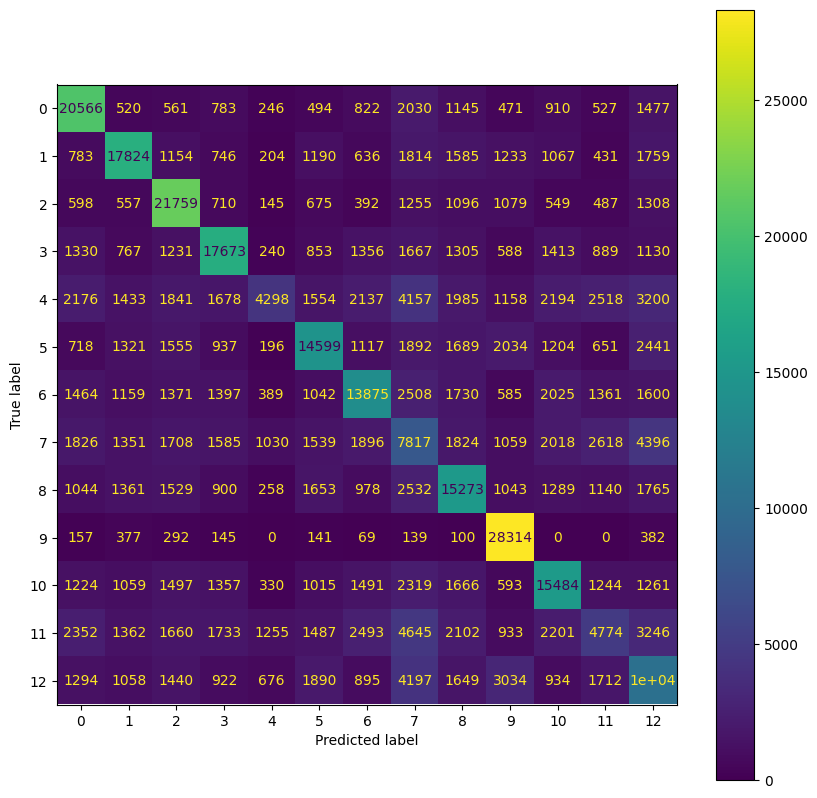

In [ ]:
# Plot confusion matrix 
cm = confusion_matrix(y_test, y_pred, labels=np.array(RMEncoding))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=np.array(RMEncoding))

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)

print("Accuracy of XGBoost  model: {:.2f}".format(accuracy))

## Save Model 

In [ ]:
# import pickle

# TARGET_MODEL_PATH += '/xgboost_model.bin'

# ##dump the model into a file
# with open(TARGET_MODEL_PATH, 'wb') as f_out:
#     pickle.dump(bst, f_out) # write final_model in .bin file
#     f_out.close()  # close the file 
#     print("Exported Model Successfully")  

### Multiple Model Excution

#  ---------------------- Further Feature Extraction with ANF Fourier Transform -----------------------------------

In [ ]:
# def feature_extraction(features, spectrum, spectrumTwo):
#     average = sum(spectrum) / len(spectrum)
#     features.append(average)
#     ###################################
#     median = np.median(spectrum)
#     features.append(median)
#     ###################################
#     maximum = np.max(spectrum)
#     features.append(maximum)
#     ###################################
#     minimum = np.min(spectrum)
#     features.append(minimum)
#     ###################################
#     peak = (len(spectrum) / 3) / (average)
#     features.append(peak)
#     ###################################
#     peak_two = (len(spectrumTwo) / 3) / (np.mean(spectrumTwo))
#     features.append(peak_two)
#     ###################################
#     standard_deviation = np.std(spectrum)  # standard deviation
#     features.append(standard_deviation)
#     ###################################
#     standard_deviation_pop = statistics.stdev(spectrum)  # population sample standard deviation
#     features.append(standard_deviation_pop)
#     ###################################
#     percentile15 = np.percentile(spectrum, 15)
#     features.append(percentile15)
#     ###################################
#     percentile25 = np.percentile(spectrum, 25)
#     features.append(percentile25)
#     ###################################
#     percentile50 = np.percentile(spectrum, 50)
#     features.append(percentile50)
#     ###################################
#     percentile75 = np.percentile(spectrum, 75)
#     features.append(percentile75)
#     ###################################
#     amplitude = maximum - minimum
#     features.append(amplitude)
#     ###################################
#     # mode = statistics.mode(spectrum)
#     ###################################
#     variance = statistics.variance(spectrum)
#     features.append(variance)
#     ###################################
#     interquartile_range = np.percentile(spectrum, 75) - np.percentile(spectrum, 25)
#     features.append(interquartile_range)
#     ###################################
#     semi_interquartile_range = (np.percentile(spectrum, 75) - np.percentile(spectrum, 25)) / 2
#     features.append(semi_interquartile_range)
#     ###################################
#     coefficient_of_variation = standard_deviation / average
#     features.append(coefficient_of_variation)
#     ###################################
#     skewness = (3 * (average - median)) / standard_deviation
#     features.append(skewness)
#     ###################################
#     kurtosis = (np.percentile(spectrum, 75) - np.percentile(spectrum, 25)) / (
#             2 * (np.percentile(spectrum, 90) - np.percentile(spectrum, 10)))
#     features.append(kurtosis)
#     ###################################
#     return

# def accumulated_nucle_frequency_fourier(seq):
#     mapping = []
#     spectrumTwo = []
#     spectrum = []
#     features = []
#     A = 0
#     C = 0
#     T = 0
#     G = 0
    
#     for i , v in seq.items():
#         if v == 'A':
#             A += 1
#             mapping.append(A / (i + 1))
#         elif v == 'C':
#             C += 1
#             mapping.append(C / (i + 1))
#         elif v == 'T' or seq[i] == 'U':
#             T += 1
#             mapping.append(T / (i + 1))
#         else:
#             G += 1
#             mapping.append(G / (i + 1))
            
#     Fmap = fft(mapping)
#     for i in range(len(mapping)):
#         specTotal = (abs(Fmap[i]) ** 2)
#         specTwo = (abs(Fmap[i]))
#         spectrum.append(specTotal)
#         spectrumTwo.append(specTwo)
#     feature_extraction(features, spectrum, spectrumTwo)
#     return features


In [ ]:
# # Encode with Fourier Transform 
# def encode_x_with_fourier(x_train_raw):
#     middle_index = (x_train_raw.shape[1] // 2) + 1
#     truncated_df = x_train_raw.iloc[:, middle_index - WINDOW_SIZE - 1: middle_index + WINDOW_SIZE]
#     result = truncated_df.apply(accumulated_nucle_frequency_fourier, axis=1)
#     return result 

# x_train_encoded_fourier = encode_x_with_fourier(x_train_raw)

# print(x_train_encoded_fourier.shape)

In [ ]:
# # Train Model Again 

# x_train_f= x_train_encoded_fourier.tolist()
# y_train_f = y_train_original 

# from imblearn.over_sampling import SMOTE
# sm = SMOTE(random_state=42)
# x_res_f, y_res_f = sm.fit_resample(x_train_f, y_train_f)

# #print("Shape of X Train : " , x_train.shape , " Shape of Y Train : " , y_train.shape)

# xg_train_f = xgb.DMatrix(x_res_f, label=y_res_f)

# # setup parameters for xgboost
# param = {}
# # use softmax multi-class classification
# param['objective'] = 'multi:softmax'
# # scale weight of positive examples
# param['eta'] = 0.1
# param['max_depth'] = 6
# param['nthread'] = 4
# param['num_class'] = 13


# num_round = 5
# xgb_f = xgb.train(param, xg_train_f, num_round)


In [ ]:
# # Predict Accuracy
# y_test=  y_test_raw.apply(decode_y , axis=1)

# x_test = encode_x_with_fourier(x_test_raw).tolist()
# xg_test = xgb.DMatrix(x_test, label=y_test)

# y_pred = xgb_f.predict(xg_test)

# print(y_pred)

# # Calculate the accuracy score of the xgboost regression model
# accuracy = accuracy_score(y_test, y_pred)

# print("Accuracy of XGBoost  model: {:.2f}".format(accuracy))



# ------- Use One Hot Encoding ------------------

In [ ]:
# # Encode using one-hot encoding 
# def apply_one_hot_encode(sequence):
#     nucleotides = ['C', 'A', 'T', 'G']
#     one_hot = []
#     for nucleotide in sequence:
#         # For G - [0,0,1,0]
#         if nucleotide == 'N': # N is not application , used for empty values.
#             hot = [0,0,0,0]
#         else:
#             hot = [0 if nucleotide != nt else 1 for nt in nucleotides]

#         one_hot.append(hot)
#     return np.array(one_hot).flatten()
#     # Apply flatten to make feature 2 Dimensional as Logistic Regression only support 2D matrix as features.


# # Encode X Features Based on Middle Index
# def encode_x_with_in_hot(x_train_raw):
#     middle_index = (x_train_raw.shape[1] // 2) + 1
#     truncated_df = x_train_raw.iloc[:, middle_index - WINDOW_SIZE - 1: middle_index + WINDOW_SIZE]
#     print(truncated_df.shape)
#     result = truncated_df.apply(apply_one_hot_encode, axis=1)
#     return result 

# x_encoded = encode_x_with_in_hot(x_train_raw)


In [ ]:
#Decode Y to its Original Form . Additional Class - NonMoD added for Non Modified RNA Sequence 
# RMs = ['hAm','hCm','hGm','hTm','hm1A','hm5C','hm5U','hm6A','hm6Am','hm7G','hPsi','Atol','NonMoD']
# RMEncoding = [0,1,2,3,4,5,6,7,8,9,10,11,12]

# def decode_y(row):   
#     decoded = ''
#     for index , n in enumerate(row.tolist()) :
#         if n == 1 :
#             decoded = RMs[index]
    
#     if decoded == '':
#         return 'NonMoD'
    
#     return decoded 

# y_train_original =  y_train_raw.apply(decode_y , axis=1)
# y_train_original.value_counts()

In [ ]:
#Code Reference : https://github.com/dmlc/xgboost/blob/master/demo/multiclass_classification/train.py
# x_train= x_encoded.tolist()
# y_train = y_train_original 

# from imblearn.over_sampling import SMOTE
# sm = RandomOverSampler(random_state=42 )
# x_res, y_res = sm.fit_resample(x_train, y_train)


# print(y_res.value_counts())

In [ ]:

# clf = OneVsRestClassifier(xgb.XGBClassifier(n_jobs=-1, max_depth=4 , objective='multi:softmax' , num_class = 13))
# clf.fit(x_res, y_res )


# xg_train = xgb.DMatrix(x_res, label=y_res)

# # setup parameters for xgboost
# param = {}
# # use softmax multi-class classification
# param['objective'] = 'multi:softmax'
# # scale weight of positive examples
# param['eta'] = 0.1
# param['max_depth'] = 6
# param['nthread'] = 4
# param['num_class'] = 13


# num_round = 5
# bst = xgb.train(param, xg_train, num_round)

In [ ]:
# y_test=  y_test_raw.apply(decode_y , axis=1)

# x_test = encode_x_with_in_hot(x_test_raw).tolist()
# # xg_test = xgb.DMatrix(x_test)
# # y_pred = bst.predict(xg_test)

# y_pred = clf.predict(x_test)

# # Calculate the accuracy score of the xgboost regression model
# accuracy = accuracy_score(y_test, y_pred)

# print("Accuracy of XGBoost  model: {:.2f}".format(accuracy))

In [ ]:
# # Plot confusion matrix 
# cm = confusion_matrix(y_test, y_pred, labels=np.array(RMEncoding))
# disp = ConfusionMatrixDisplay(confusion_matrix=cm,
#                               display_labels=np.array(RMEncoding))

# fig, ax = plt.subplots(figsize=(10,10))
# disp.plot(ax=ax)

# print("Accuracy of XGBoost  model: {:.2f}".format(accuracy))

In [ ]:
# from sklearn.svm import SVC
# svm_model_linear = SVC(kernel = 'linear', C = 1).fit(x_res, y_res)
# svm_predictions = svm_model_linear.predict(x_test)
  
# # model accuracy for X_test  
# accuracy = svm_model_linear.score(x_test, y_test)
  
# # creating a confusion matrix
# cm = confusion_matrix(y_test, svm_predictions)

# LSTM Based Models

In [ ]:
# import torch
# import torch.nn as nn

# class LSTMClassifier(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size):
#         super().__init__()
#         self.hidden_size = hidden_size
#         self.lstm = nn.LSTM(input_size, hidden_size)
#         self.fc = nn.Linear(hidden_size, output_size)

#     def forward(self, input_seq):
#         # Initialize hidden state and cell state with zeros
#         h0 = torch.zeros(1, input_seq.size(1), self.hidden_size).to(device)
#         c0 = torch.zeros(1, input_seq.size(1), self.hidden_size).to(device)

#         # Forward pass through LSTM layer
#         output, (hidden, cell) = self.lstm(input_seq, (h0, c0))

#         # Get the final output of the LSTM (last hidden state)
#         final_output = hidden[-1, :, :]

#         # Forward pass through fully connected layer
#         output = self.fc(final_output)

#         # Softmax activation function to get probabilities
#         output = nn.functional.softmax(output, dim=1)
#         return output


In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim

# # # RNA sequences (input)
# # train_data = [
# #     'AUUGGCGCUUAC',
# #     'AGCUGGGAGUUCAA',
# #     'AUCUCAGGACAGUUGGCUUUGUUUGUCC',
# #     # ...
# # ]

# # Target labels (output)
# train_labels = [
#     1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13
# ]

# # One-hot encoding of RNA sequences
# #base_to_idx = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
# input_dim = 404  # A, C, G, 
# max_len = 1001

# train_data_oh = torch.from_numpy(X_train)


# # Define LSTM model
# class LSTMModel(nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim):
#         super(LSTMModel, self).__init__()
#         self.hidden_dim = hidden_dim
#         self.lstm = nn.LSTM(input_dim, hidden_dim)
#         self.fc = nn.Linear(hidden_dim, output_dim)

#     def forward(self, input_seq):
#         lstm_out, _ = self.lstm(input_seq.view(len(input_seq), 1, -1))
#         last_out = lstm_out[-1]
#         out = self.fc(last_out)
#         return out

# # Initialize model and optimizer
# hidden_dim = 16
# output_dim = 13
# model = LSTMModel(input_dim, hidden_dim, output_dim)
# optimizer = optim.Adam(model.parameters())

# # Train model
# num_epochs = 100
# loss_fn = nn.CrossEntropyLoss()

# for epoch in range(num_epochs):
#     # for i in range(len(train_data_oh)):
#     #     input_seq = train_data_oh[i]
#     label = torch.tensor([train_labels[i]], dtype=torch.long)

#     optimizer.zero_grad()
#     output = model(train_data_oh)
#     loss = loss_fn(output, label)
#     loss.backward()
#     optimizer.step()

#     if epoch % 10 == 0:
#         print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

# # Test model
# test_data = [
#     'UCCUGGGUCCAGUUCUGCUUAAACUUAGUUGCCUAA',
#     'AGCCUCUUGGGAUUGGGCUUUGUUUGUCC',
#     # ...
# ]
# MAX_SEQ_LEN = 200
# test_data_oh = torch.zeros(len(test_data), MAX_SEQ_LEN, len(base_to_idx))
# for i, seq in enumerate(test_data):
#     for j, base in enumerate(seq):
#         test_data_oh[i, j, base_to_idx[base]] = 1

# with torch.no_grad():
#     for i in range(len(test_data)):
#         input_seq = test_data_oh[i]
#         output = model(input_seq)
#         predicted_label = torch.argmax(output).item()
#         print('Test example {}: predicted label {}'.format(i+1, predicted_label))
